In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy import io as sio
import random
from sklearn.neighbors import NearestNeighbors
import gzip
import pickle
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from data import mnist
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

In [2]:
# Mask dense
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias = True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


In [3]:
# MADE architecture
class MADEnet(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, ordering, num_masks):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin  == 0
        
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU()])
        self.net.pop()
        self.net = nn.Sequential(*self.net)
        
        self.num_masks = num_masks
        self.seed = 16
        
        self.m = {}
        self.m[-1] = ordering
         
        self.direct = MaskedLinear(self.nin, self.nout)
        mask_direct = self.m[-1][:,None] < self.m[-1][None,:]
        mask_direct = np.array(mask_direct)
        print(mask_direct.shape)
        self.direct.set_mask(mask_direct)

        self.update_masks()
        
    def update_masks(self):
        if len(self.m) != 1 and self.num_masks == 1: 
            return
        L = len(self.hidden_sizes)
        
        # 1 seed -> 1 mask =>> update seed
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # random m in hidden layers
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin - 1, size = self.hidden_sizes[l])
        
        # construct masks
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None, :])
        
        # use for other output distributions 
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            masks[-1] = np.concatenate([masks[-1]]*k, axis = 1)
            
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers,  masks):
            l.set_mask(m)

  
    
    def forward(self, x):
        return self.net(x)
        #return self.net(x) + self.direct(x)

In [4]:
class MADE():
    def __init__(self, hiddens='1024', num_masks=1, ordering='raster-scan', 
               samples=1, resample_every=20, data='mnist', imgshape = (28,28,1)):
    # tunning params
        self.hiddens = hiddens
        self.num_masks = num_masks
        self.ordering = ordering 
        self.samples = samples
        self.resample_every = resample_every
        self.data_path_vol = 'C:\Projekte\dev\git\Masterarbeit\\'
        self.data_path_faces = 'C:\\Projekte\\dev\\git\\Masterarbeit\\MADE\\'
        self.data_path_binmnist = 'C:\\Projekte\\dev\\git\\Masterarbeit\\made-master\\made-master\\data\\binarized_mnist.npz'
        self.data_path_mnist = 'C:\\Projekte\\dev\\git\\Masterarbeit\\made-master\\made-master\\data\\mnist.npz'
        self.data_path_emnist = '/content/drive/My Drive/datasets/emnist-letters.mat'
        self.data_path_shape = '/content/drive/My Drive/datasets/shapes/data.npy'
        self.imgshape = imgshape
        np.random.seed(16)
        torch.manual_seed(16)
        torch.cuda.manual_seed_all(16)

        # loading data
        print("Loading data ...")
        if data == 'vol':
            print("Dataset Volatility")
            self.load_data_vol()
        elif data == 'faces':
            print("Dataset Faces")
            self.load_data_faces()
        elif data =='emnist':
            print("Dataset EMNIST")
            self.load_data_emnist()
        elif data =='mnist':
            print("Dataset MNIST")
            self.load_data_mnist()        
        elif data =='binmnist':
            print("Dataset Binarized MNIST")
            self.load_data_binmnist()
        elif data =='shape':
            print("Dataset SHAPE")
            self.load_data_shape()
        print("Loading data done")
        print("------------------------------")

        # Construct mode and ship to GPU
        print("Constructing MADE architecture ...")

        hidden_list = list(map(int, self.hiddens.split(',')))

          #create order
        if self.ordering == 'raster-scan':
            self.order = np.arange(self.xtr.size(1))
        elif self.ordering =='columns':
            a = np.arange(0, self.xtr.size(1)).reshape(self.imgshape)
            x = a.T
            self.order = x.reshape(self.xtr.size(1))
        elif self.ordering == 'randoms':
            self.order = np.random.RandomState(16).permutation(self.xtr.size(1))
        elif self.ordering == 'reverseRS':
            self.order = np.arange(self.xtr.size(1))[::-1]
        elif self.ordering == 'top_down_mid':
            l = self.xtr.size(1)
            top = np.arange(self.xtr.size(1))
            down = top[l//2:][::-1]
            self.order = np.concatenate([top[:l//2], down])

        self.model = MADEnet(nin = self.xtr.size(1), hidden_sizes=hidden_list, 
                             nout=self.xtr.size(1), ordering=self.order, num_masks=self.num_masks)
        self.model.cuda()

        #set up the optimizer
        self.opt = torch.optim.Adam(self.model.parameters(), 1e-3, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=45, gamma=0.1)
        print("Constructing MADE architecture done")
        print("------------------------------")
   
    def reconstruct(self, n):
        rng = np.random.randint(low = 0, high = self.xtr.size(0), size = n, dtype=int)
        l = self.xtr.size(1)
        origin = [self.xtr[i].tolist() for i in rng]
        origin = np.array(origin).astype(np.float32)
        origin_all = [self.xtr[i].tolist() for i in rng]
        origin_all = np.array(origin_all).astype(np.float32)
        deconstruct = origin
        deconstruct[:,l//2:] = 0
        x  = torch.from_numpy(deconstruct).cuda()
        x = x.reshape(n,28*28)
        samples  = torch.from_numpy(deconstruct).cuda()
        samples = x.reshape(n,28*28)
        #example_surface = np.reshape(origin,(len(x),28,28,1))
        #print(example_surface.shape)
        mu = torch.zeros(n, 784).cuda()
        var = torch.ones(n, 784).cuda()
        with torch.no_grad():
            eps = samples.clone().normal_(0, 1)
            for i in range(l//2 + 1, l, 1):
                logits = self.model(x)[:,i].cuda()
                #print(logits)
                probs = torch.sigmoid(logits).cuda()
                #print(probs)
                x[:,i] = torch.bernoulli(probs)
                #x[:,i] = torch.binomial(torch.tensor(784.0).cuda(), probs)
                #print(x[:,i])
                #x[:,i] = torch.normal(mu[:,i], var[:,i])
                #x[:, i] = mu[:, i] + torch.exp(var[:, i]) * eps[:, i]
            
                #samples[:, i] = (torch.sigmoid(samples[:, i]) - 1e-6) / (1 - 2e-6)
                #samples[:, i] = samples[:, i].detach().cpu().view(n, 28, 28)
                #x[:,i] = samples[:,i]
            x = x.view(n, self.xtr.size(1))
            #x = x.view(n, 28*28)
        #origin_all = np.reshape(origin_all,(len(origin_all),28,28,1))
        #origin = np.reshape(origin,(len(origin),28,28,1))
        x = np.array(x.tolist()).astype(np.float32) 
        #x = np.reshape(x,(len(x),28,28,1))
        return origin_all, origin, x
        #return origin_all, origin, np.array(x.tolist()).astype(np.float32) 
    

    def sample(self, n, resample = True):
        noise = torch.rand(n, self.xtr.size(1)).cuda()
        samples = self.samples if resample else 1
        with torch.no_grad():
            for i in self.order:
                logits = torch.zeros(n).cuda()
                # resampling
                for s in range(samples):
                        logits += self.model(noise)[:, i]
                logits = logits / samples
                probs = torch.sigmoid(logits)
                noise[:, i] = torch.bernoulli(probs)
            noise = noise.view(n, self.xtr.size(1))
        return np.array(noise.tolist()).astype(np.int32)
  
    def get_nearest_real_images(self, xfake):
        # Kneighbor algo for comparing
        self.nrnb = NearestNeighbors(n_neighbors= 1, p=2)
        self.nrnb.fit(self.xtr.tolist())
        indices = self.nrnb.kneighbors(xfake, return_distance=False)
        tmp = self.xtr.tolist()
        xnearest = [tmp[i[0]] for i in indices]
        xnearest = np.array(xnearest).astype(np.int32)
        return xnearest

    def gen_fake_and_save(self, filename, resample):
        xfake = self.sample(100, resample= resample)
        fig=plt.figure(figsize=(8, 8))
        columns = 10
        rows = 10
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(xfake[i-1].reshape(self.imgshape), cmap ='gray')
        #plt.savefig(filename)
        plt.show()

    def training(self, epochs, batch_size):
        path = "C:\\Projekte\\dev\\git\\"
        self.batch_size = batch_size
        self.test_loss = []
        self.train_loss = []
        print("Start training")
        for epoch in range(epochs):
            print("Epoch %d" % (epoch, ))
            self.scheduler.step(epoch)
            te_loss = self.run_epoch('test', upto= 5)
            tr_loss = self.run_epoch('train')
            self.test_loss.append(te_loss)
            self.train_loss.append(tr_loss)
            #if epoch % 10 == 0 or epoch + 1 == epochs:
                #filename = "epoch"+str(epoch)+".png";
                #self.gen_fake_and_save(path+filename, False)
        print("Training done")
  
    def load_data_vol(self):
        dat = np.loadtxt(self.data_path_vol + 'HestonTrainSet_ivol_201_neu_klein.txt')
        NModelPar = 5 
        yy=dat[:len(dat),:NModelPar]                           
        xx=dat[:len(dat),NModelPar:] 
        
        #scalex = StandardScaler()

        #xx_transform = scalex.fit_transform(xx)
        #x_train, x_test, y_train, y_test = train_test_split(xx_transform, yy, test_size=0.33, random_state=42)
        x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.33, random_state=42)
        
        x_train = np.reshape(x_train,(len(x_train),28*28))
        print(x_train.shape)
        x_test = np.reshape(x_test,(len(x_test),28*28))
        print(x_test.shape)

        x_train = x_train.astype(np.float32)
        x_test = x_test.astype(np.float32)
        self.xtr = torch.from_numpy(x_train).cuda()
        self.xte = torch.from_numpy(x_test).cuda()

    def load_data_faces(self):
        # Download Olivetti faces dataset
        olivetti = fetch_olivetti_faces()
        x = olivetti.images
        y = olivetti.target
        X = x.reshape((400, 4096))
        X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.05, random_state=42)
        x_train = X_train.astype(np.float32)
        x_test = X_test.astype(np.float32)
        self.xtr = torch.from_numpy(x_train).cuda()
        self.xte = torch.from_numpy(x_test).cuda()
    
    def load_data_shape(self):
        X = np.load(self.data_path_shape)
        indices = np.arange(0, X.shape[0])
        random.shuffle(indices)
        X = X[indices].astype(np.float32)
        l = 1600
        xtr, xte = X[indices[:l]], X[indices[l:]]
                 
        self.xtr = torch.from_numpy(xtr).cuda()
        self.xte = torch.from_numpy(xte).cuda()

    def load_data_binmnist(self):
        binmnist = np.load(self.data_path_binmnist)
        self.xtr, self.xte = binmnist['train_data'], binmnist['valid_data']
        self.xtr = torch.from_numpy(self.xtr).cuda()
        self.xte = torch.from_numpy(self.xte).cuda()
  
    def load_data_mnist(self):
        mnist_ = mnist.MNIST()
        train, val, _ = mnist_.get_data_splits()
        #min_max_scaler = preprocessing.MinMaxScaler()
        #train = min_max_scaler.fit_transform(train)
        #val = min_max_scaler.fit_transform(val)
        #train = torch.from_numpy(train)
        #val = torch.from_numpy(val)
        self.xtr, self.xte = train, val
        self.xtr = train.cuda()
        self.xte = val.cuda()

   
    def load_data_emnist(self):
        mat = sio.loadmat(self.data_path_emnist)
        data = mat['dataset']
        X_train = data['train'][0,0]['images'][0,0]
        X_test = data['test'][0,0]['images'][0,0]
        X_train = X_train.reshape(X_train.shape[0], 28, 28, order="F")
        X_test = X_test.reshape(X_test.shape[0], 28, 28 , order="F")
        X_train = X_train.reshape(X_train.shape[0], 784, order='C').astype(np.float32)
        X_test = X_test.reshape(X_test.shape[0], 784, order='C').astype(np.float32)
        X_train = np.round(X_train / 255.)
        X_test = np.round(X_test/ 255.)
        self.xtr = torch.from_numpy(X_train).cuda()
        self.xte = torch.from_numpy(X_test).cuda()
    
    def run_epoch(self, split, upto = None):
        torch.set_grad_enabled(split == 'train')
        if split == 'train': self.model.train()
        else: self.model.eval()
    
        x = self.xtr if split == 'train' else self.xte
        samples = 1 if split == 'train' else self.samples
        x = x.reshape(-1, 28 * 28)
        N,D = x.size()
        B = self.batch_size
        nsteps = N//B if upto is None else min(N//B, upto)
        lossfs = []
        # An epoch has many batches
        for step in range(nsteps):
            # Get next batch data shape [B, D]
            xb = Variable(x[step*B:step*B+B])
            # A batch is fed through net many times (nsamples)
            # Calculate mean of xbhat
            xbhat = torch.zeros_like(xb)
            for s in range(samples):
                # perform order/connectivity-agnostic training by resampling the masks
                if step % self.resample_every == 0 or split == 'test': # if in test, cycle masks every time
                    self.model.update_masks()
                # forward the model
                xbhat += self.model(xb.float())
            xbhat /= samples
            
            
            x_recon = F.sigmoid(xbhat)
            loss = F.mse_loss(x_recon, xb, size_average=False).div(B)
            # Evaluate the binary cross entropy loss
            #loss = F.binary_cross_entropy_with_logits(xbhat, xb, size_average=False) / B
            #var = torch.ones(32, 784).cuda()
            #loss = F.gaussian_nll_loss(xbhat, xb, var=var) #/ B
            #lossf = loss.data.item()
            lossfs.append(loss.cpu().detach().numpy())
            # backward/update
            if split == 'train':
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
        
        #lossfs = np.array(lossfs)
        mean_loss = np.mean(lossfs)
        print("%s epoch loss: %f" % (split, mean_loss))
        return mean_loss

    def draw_epoch_loss(self):
        plt.plot(self.train_loss, label='train')
        plt.plot(self.test_loss, label='test')
        plt.legend(loc='best')
        plt.show()

In [9]:
hiddens = '1024,1024'
imgshape = (28,28)
epochs = 75
batch_size = 32

In [10]:
made = MADE(hiddens = hiddens, num_masks = 5, data = 'binmnist', ordering='raster-scan',samples = 10, 
            resample_every=40, imgshape=imgshape)

Loading data ...
Dataset Binarized MNIST
Loading data done
------------------------------
Constructing MADE architecture ...
(784, 784)
Constructing MADE architecture done
------------------------------


In [ ]:
made.training(epochs, batch_size)

In [ ]:
made.draw_epoch_loss()

In [ ]:
string = "_".join([str(h) for h in hiddens])
torch.save(
    {
        "epoch": epochs,
        "model_state_dict": made.model.state_dict(),
        "optimizer_state_dict": made.opt.state_dict(),
        "scheduler_state_dict": made.scheduler.state_dict(),
    },
    "./model_vol_" + string + ".pt",
)

In [13]:
string = "_".join([str(h) for h in hiddens])

checkpoint = torch.load("model_binmnist_" + string + ".pt")
made.model.load_state_dict(checkpoint["model_state_dict"])
tot_epochs = checkpoint["epoch"]

In [21]:
def reconstructing(n, filename):
    before_all, before, after = made.reconstruct(n)
    print(before_all.shape)
    print(before_all)
    print(before.shape)
    print(before)
    print(after.shape)
    print(after)
    fig = plt.figure(figsize = (10,10))
    columns = 3
    rows = n
    for i in range(0, n):
        fig.add_subplot(rows, columns, 3*i+1)
        plt.imshow(before_all[i].reshape(made.imgshape).squeeze())
        #plt.imshow(before_all[i].reshape(made.imgshape))
        
        fig.add_subplot(rows, columns, 3*i+2)
        plt.imshow(before[i].reshape(made.imgshape).squeeze())
        #plt.imshow(before[i].reshape(made.imgshape))
        
        fig.add_subplot(rows, columns, 3*i+3)
        plt.imshow(after[i].reshape(made.imgshape).squeeze())
        #plt.imshow(after[i].reshape(made.imgshape))
    plt.savefig(filename)

(5, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(5, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(5, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


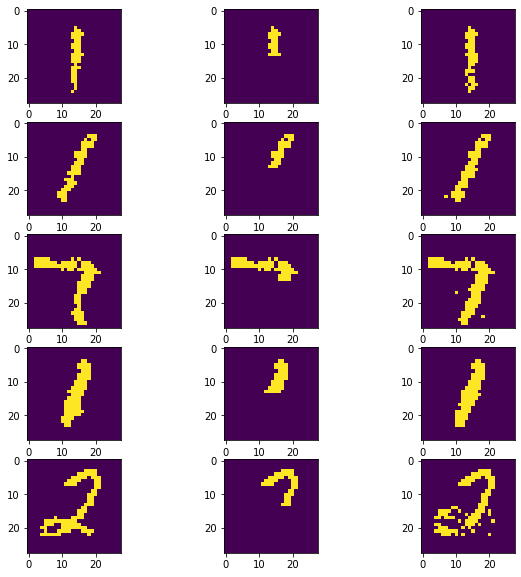

In [22]:
reconstructing(5, "C:\\Projekte\\dev\\git\\reconstructingx_binmnist.png")

In [ ]:
strikes=np.array([0.500000000000000, 0.537037037037037, 0.574074074074074, 0.611111111111111, 0.648148148148148, 
                  0.685185185185185, 0.722222222222222, 0.759259259259259, 0.796296296296296, 0.833333333333333,
                  0.870370370370370, 0.907407407407407, 0.944444444444444, 0.981481481481481, 1.01851851851852,
                  1.05555555555556,  1.09259259259259,  1.12962962962963,  1.16666666666667, 1.20370370370370,
                  1.24074074074074, 1.27777777777778, 1.31481481481481, 1.35185185185185,   1.38888888888889,
                  1.42592592592593, 1.46296296296296, 1.50000000000000])                

maturities=np.array([0.500000, 0.851852, 1.203704, 1.555556, 1.907407, 2.259259, 2.611111, 2.962963, 3.314815, 
                     3.666667,4.018519, 4.370370, 4.722222, 5.074074, 5.425926, 5.777778, 6.129630, 6.481481, 
                     6.833333, 7.185185, 7.537037, 7.888889, 8.240741, 8.592593, 8.944444, 9.296296, 9.648148,
                     10.000000])

In [ ]:
n = 5
before_all, before, after = made.reconstruct(n)
after = np.reshape(after,(n,784,1))
fig = plt.figure(figsize = (5,5))
columns = 2
rows = n
before = np.reshape(before,(len(before),28,28,1))

ax = fig.gca(projection='3d')
ax.plot_surface(strikes, maturities, before[0].reshape(made.imgshape).squeeze(), cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
#plt.savefig('vol_original_half')   
#   ax.plot_surface(strikes, maturities, after[i].reshape(made.imgshape).squeeze(), cmap=cm.coolwarm,
#                      linewidth=0, antialiased=False)

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca(projection='3d')
after = np.reshape(after,(len(after),28,28,1))
ax.plot_surface(strikes, maturities, after[0].reshape(made.imgshape).squeeze(), cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
#plt.savefig('vol_prop') 

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca(projection='3d')
ax.plot_surface(strikes, maturities, before_all[0].reshape(made.imgshape).squeeze(), cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
#plt.savefig('vol_original') 

In [ ]:
before_all[0]-(after.reshape(n,28*28)[0])
#after

In [ ]:
unique, counter = np.unique(before_all[0]-(after.reshape(n,28*28)[0]), return_counts=True)

In [ ]:
len(unique)


In [42]:
torch.tensor(5.0).cuda()

tensor(5., device='cuda:0')

In [24]:
dat = np.loadtxt('C:\Projekte\dev\git\Masterarbeit\\HestonTrainSet_ivol_201_neu_groß.txt')

In [29]:
dat.max()

0.9227170726870725